# Evolutionary Computation Assignment 3

##### Solutions checked by solution checker

- Krzysztof Szala 144571
- Vadym Repetskyi 155610


In [1]:
from utils import TspInstance, random_solution, weighted_regret, greedy_cycle
import numpy as np
import pandas as pd
import itertools

In [2]:
def intra_route_move(tsp, solution, intra_type, steepest):
    solution = solution.copy()
    indexes = range(len(solution))
    neighborhood = [(u, v) for u in indexes for v in indexes if u != v]
    np.random.shuffle(neighborhood)

    min_cost = 0
    selected_a = selected_b = None

    for index_a, index_b in neighborhood:
        # we can draw first edge with any node, but second have to start from not node_a and not node_a+1 or node_a-1
        if intra_type != "nodes" and abs(index_a - index_b) == 1:
            continue

        a = solution[index_a]
        b = solution[index_b]

        a_prev = solution[index_a - 1]
        b_prev = solution[index_b - 1]
        if index_a - 1 < 0:
            a_prev = solution[len(solution) - 1]
        if index_b - 1 < 0:
            b_prev = solution[len(solution) - 1]

        a_next = solution[(index_a + 1) % len(solution)]
        b_next = solution[(index_b + 1) % len(solution)]
        
        a_next_next = solution[(index_a + 2) % len(solution)]
        b_next_next = solution[(index_b + 2) % len(solution)]

        if intra_type == "nodes":
            if abs(index_a - index_b) == 1: # Adjacent case
                if index_a < index_b:  # Case where a is directly before b
                    cost_change = (
                        tsp.distance_matrix[a_prev, b]
                        + tsp.distance_matrix[a, b_next]
                        - tsp.distance_matrix[a_prev, a]
                        - tsp.distance_matrix[b, b_next]
                    )
                else:  # Case where b is directly before a
                    cost_change = (
                        tsp.distance_matrix[b_prev, a]
                        + tsp.distance_matrix[b, a_next]
                        - tsp.distance_matrix[b_prev, b]
                        - tsp.distance_matrix[a, a_next]
                    )
            elif abs(index_a - index_b) == len(solution) - 1:  # Adjacent case - last and first node
                if index_a > index_b:
                    cost_change = (
                        tsp.distance_matrix[a_prev, b]
                        + tsp.distance_matrix[a, b_next]
                        - tsp.distance_matrix[a_prev, a]
                        - tsp.distance_matrix[b, b_next]
                    )
                else:
                    cost_change = (
                        tsp.distance_matrix[b_prev, a]
                        + tsp.distance_matrix[b, a_next]
                        - tsp.distance_matrix[b_prev, b]
                        - tsp.distance_matrix[a, a_next]
                    )
            else:
                # Non-adjacent case, use the general formula
                cost_change = (
                    tsp.distance_matrix[a_prev, b]
                    + tsp.distance_matrix[b, a_next]
                    + tsp.distance_matrix[b_prev, a]
                    + tsp.distance_matrix[a, b_next]
                    - tsp.distance_matrix[a_prev, a]
                    - tsp.distance_matrix[a, a_next]
                    - tsp.distance_matrix[b_prev, b]
                    - tsp.distance_matrix[b, b_next]
                )

        else:
            cost_change = (
                tsp.distance_matrix[a, b]
                + tsp.distance_matrix[a_next, b_next]
                # + tsp.distance_matrix[b, a_next_next]
                # + tsp.distance_matrix[a_next, b_prev]
                - tsp.distance_matrix[a, a_next]
                - tsp.distance_matrix[b, b_next]
            )

        if cost_change < min_cost:
            min_cost = cost_change
            selected_a = index_a
            selected_b = index_b

            if not steepest:
                break

    if selected_a is not None:
        if intra_type == "nodes":
            # Just swap the two nodes
            solution[selected_a], solution[selected_b] = (
                solution[selected_b],
                solution[selected_a],
            )
        else:
            if selected_a < selected_b:
                subsequence = solution[(selected_a + 1):selected_b+1][::-1]
                solution[(selected_a + 1):selected_b+1] = subsequence
            else:
                subsequence = solution[(selected_b + 1):selected_a+1][::-1]
                solution[(selected_b + 1):selected_a+1] = subsequence

    return solution, min_cost


def inter_route_move(tsp, solution, steepest):
    solution = solution.copy()
    possible_unselect = set(solution)
    possible_select = set(range(tsp.size)) - possible_unselect
    neighborhood = list(itertools.product(possible_unselect, possible_select))
    np.random.shuffle(neighborhood)

    min_cost = 0
    to_unselect = to_select = None

    for test_unselect, test_select in neighborhood:
        insert_index = np.where(solution == test_unselect)[0][0]

        prev = solution[insert_index - 1]
        next = solution[(insert_index + 1) % len(solution)]

        cost_change = (
            tsp.node_costs[test_select]
            + tsp.distance_matrix[prev, test_select]
            + tsp.distance_matrix[test_select, next]
            - tsp.node_costs[test_unselect]
            - tsp.distance_matrix[prev, test_unselect]
            - tsp.distance_matrix[test_unselect, next]
        )

        if cost_change < min_cost:
            min_cost = cost_change
            to_unselect = test_unselect
            to_select = test_select

            if not steepest:
                break

    if to_unselect is not None and not steepest:
        solution[np.where(solution == to_unselect)] = to_select

    if steepest:
        return min_cost, to_unselect, to_select
    else:
        return solution, min_cost

In [ ]:
solution = [1, 2, 3, 33, 54, 55, 5]
selected_a = 5
selected_b = 1

if selected_a < selected_b:
    subsequence = solution[(selected_a + 1):selected_b+1][::-1]
    solution[(selected_a + 1):selected_b+1] = subsequence
else:
    subsequence = solution[(selected_b + 1):selected_a+1][::-1]
    solution[(selected_b + 1):selected_a+1] = subsequence

print(solution)

## Local Search

### Greedy

1. Generate initial solution (random or best heuristic so far)
2. Until you don't find any improving solution:
    1. Randomly select move from your neighbourhood, that means
        1. Randomly choose if inter/intra route move (if it's greedy, for steepest it doesn't matter)
        2. Randomly look for next solution, remembering already visited solutions (after visiting all intra/inter moves without getting cost change decrease, check the other all possible moves within inter/intra space)
    2. Iterate over all possible moves, until you find first which decrease cost (cost change would be negative) or if you would check all possible moves.
    3. Apply improving move to the solution
3. Return solution

### Steepest

1. Generate initial solution (random or best heuristic so far)
2. Until you don't find any improving solution:
    1. Check all possible moves from your neighbourhood and choose a move with the biggest decrease of cost.
    3. Apply improving move to the solution
3. Return solution

In [4]:
def local_search(
    tsp: TspInstance,
    start_node: int,
    initial_solution_getter: callable,
    intra_type: str,
    steepest: bool,
):
    solution = initial_solution_getter(tsp, start_node)

    debug = False
    if debug:
        previous = list()
        
        last_sol = None
    counter = 0 
    while True:
        counter += 1
        if debug:
            last_sol = solution.copy()
            previous.append((str(solution), counter))
        
        if steepest:
            cost_change_1, to_unselect, to_select = inter_route_move(tsp, solution, steepest)
            solution_2, cost_change_2 = intra_route_move(
                tsp, solution, intra_type, steepest
            )
            if cost_change_1 < cost_change_2:
                cost_change = cost_change_1
                if to_unselect is not None:
                    solution[np.where(solution == to_unselect)] = to_select
            else:
                solution, cost_change = solution_2, cost_change_2
        else:
            if np.random.rand() < 0.5:
                solution, cost_change = inter_route_move(tsp, solution, steepest)

                if cost_change == 0:
                    solution, cost_change = intra_route_move(
                        tsp, solution, intra_type, steepest
                    )
            else:
                solution, cost_change = intra_route_move(
                    tsp, solution, intra_type, steepest
                )

                if cost_change == 0:
                    solution, cost_change = inter_route_move(tsp, solution, steepest)

        if cost_change == 0:
            break

        if debug:
            if str(solution) in [x[0] for x in previous]:
                
                last_cost = tsp.get_cost(last_sol)
                current_cost = tsp.get_cost(solution)
                
                if last_cost < current_cost:
                
                    print("Previous solution")
                    print(str(previous[-1][0]))
                    list_previous = [x[1] for x in previous if x[0] == str(solution)]
                    print("Current solution")
                    print(str(solution))
                    
                    print("Last cost", last_cost)
                    print("Current cost", current_cost)
                    print("Already seen solution", "Current cost_change: ", cost_change, " in previous iteration ", list_previous)
    # print("Counter: ", counter)
    return solution

## Experiments


A STEEPEST NODES RANDOM


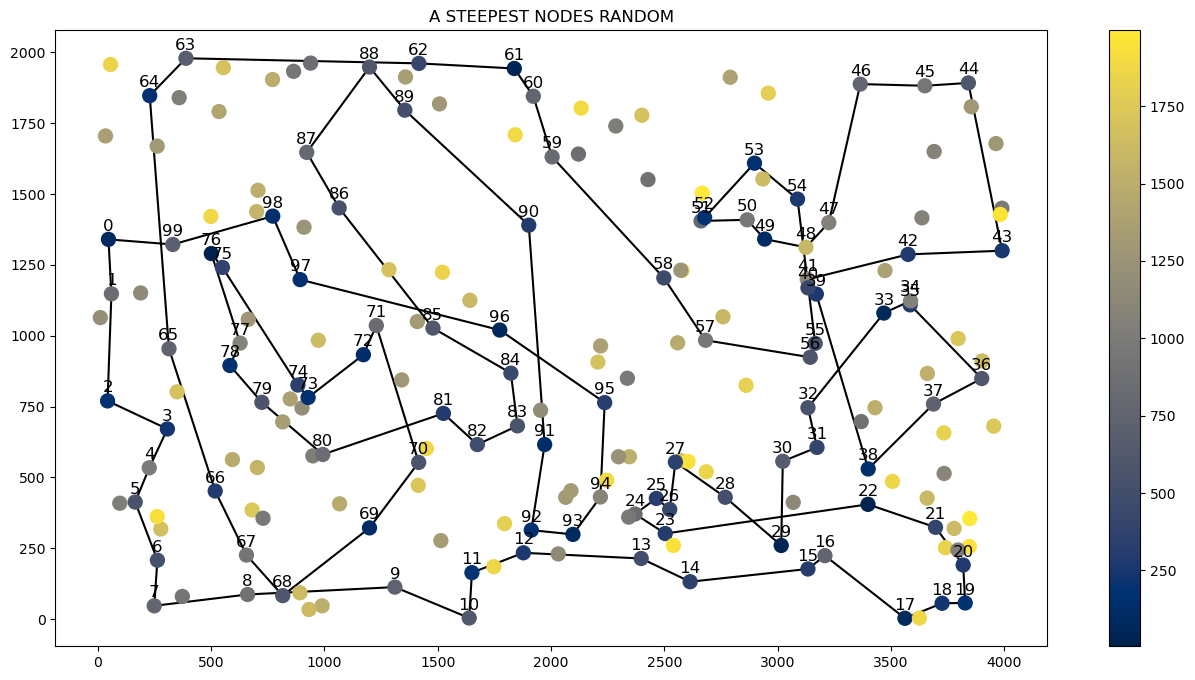

A STEEPEST NODES GREEDY


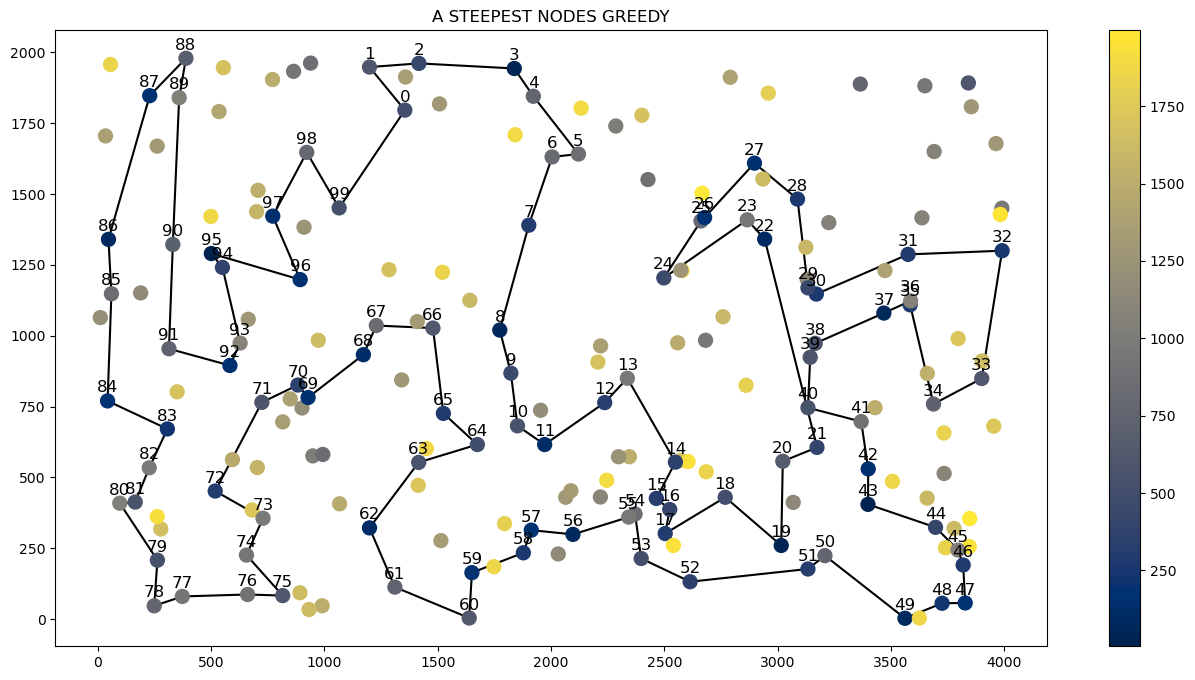

A GREEDY NODES RANDOM


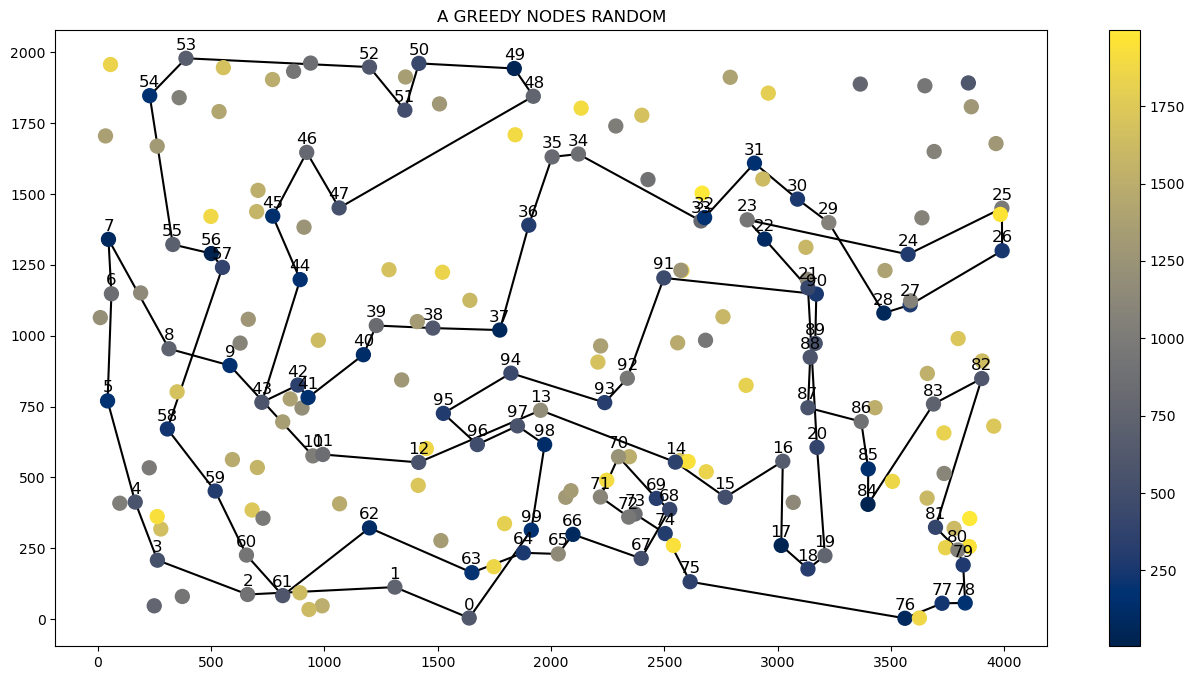

A GREEDY NODES GREEDY


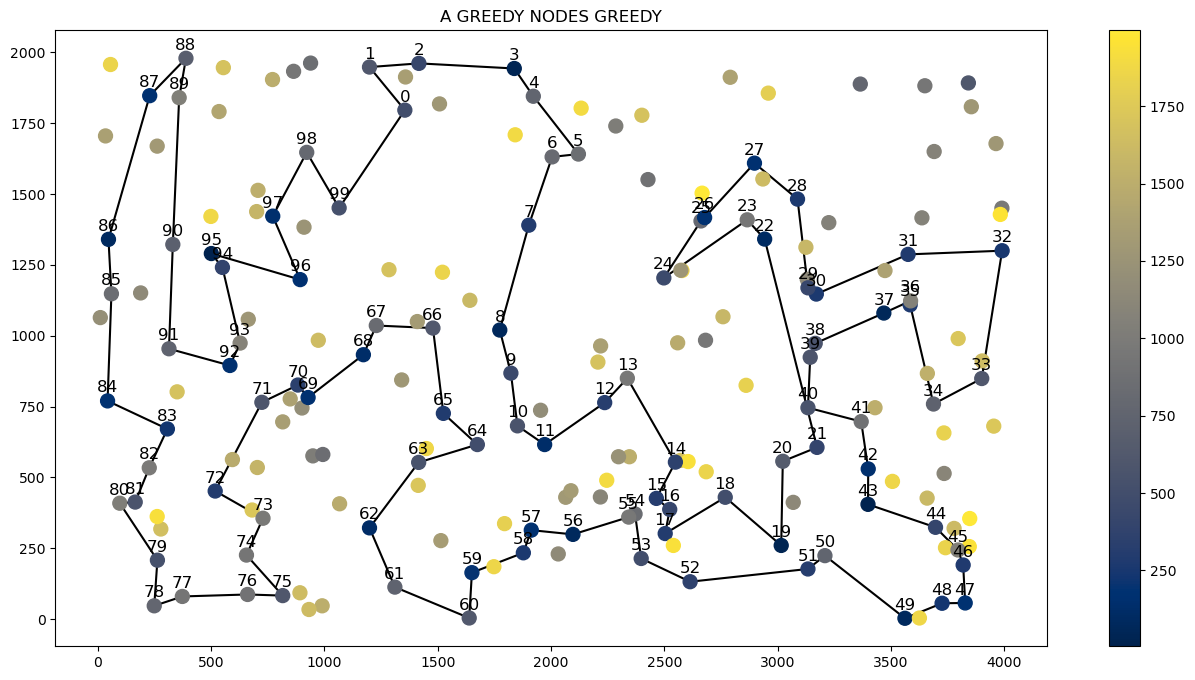

A STEEPEST EDGES RANDOM


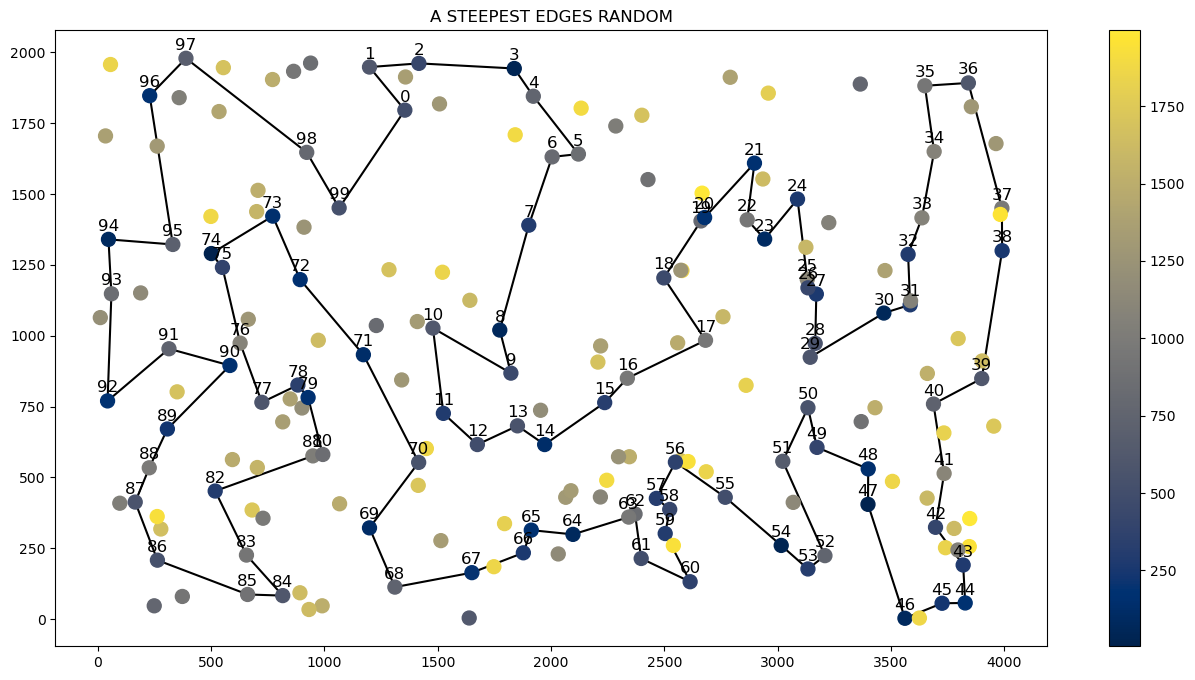

A STEEPEST EDGES GREEDY


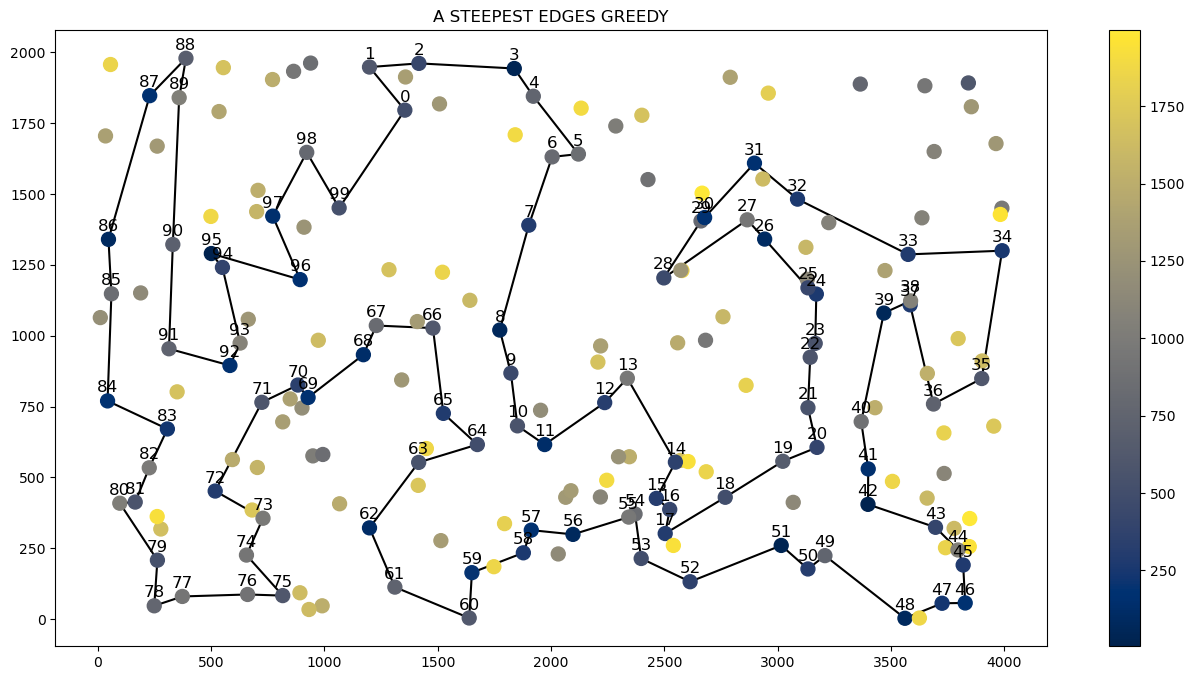

A GREEDY EDGES RANDOM


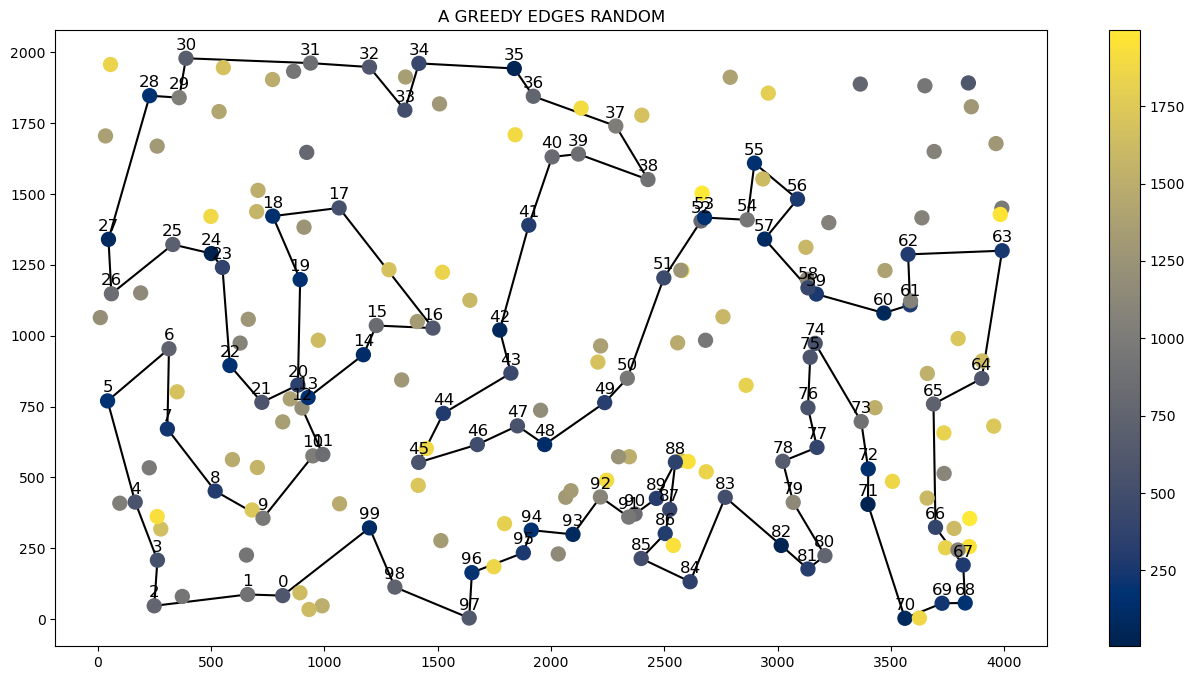

A GREEDY EDGES GREEDY


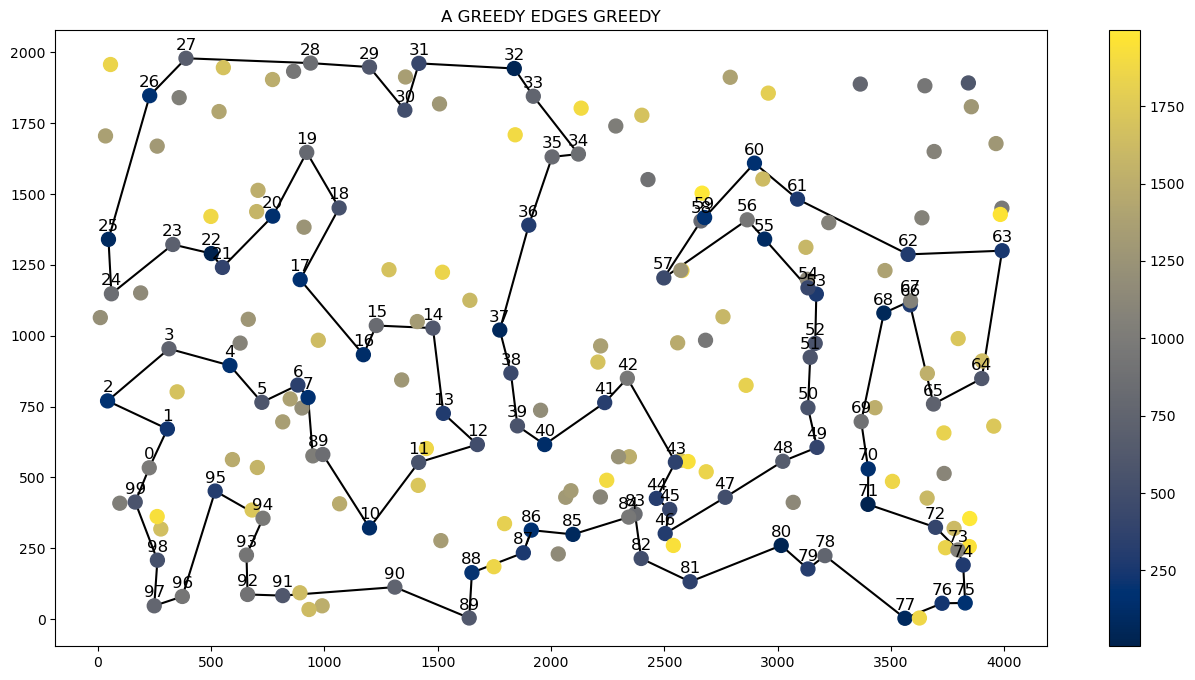

B STEEPEST NODES RANDOM


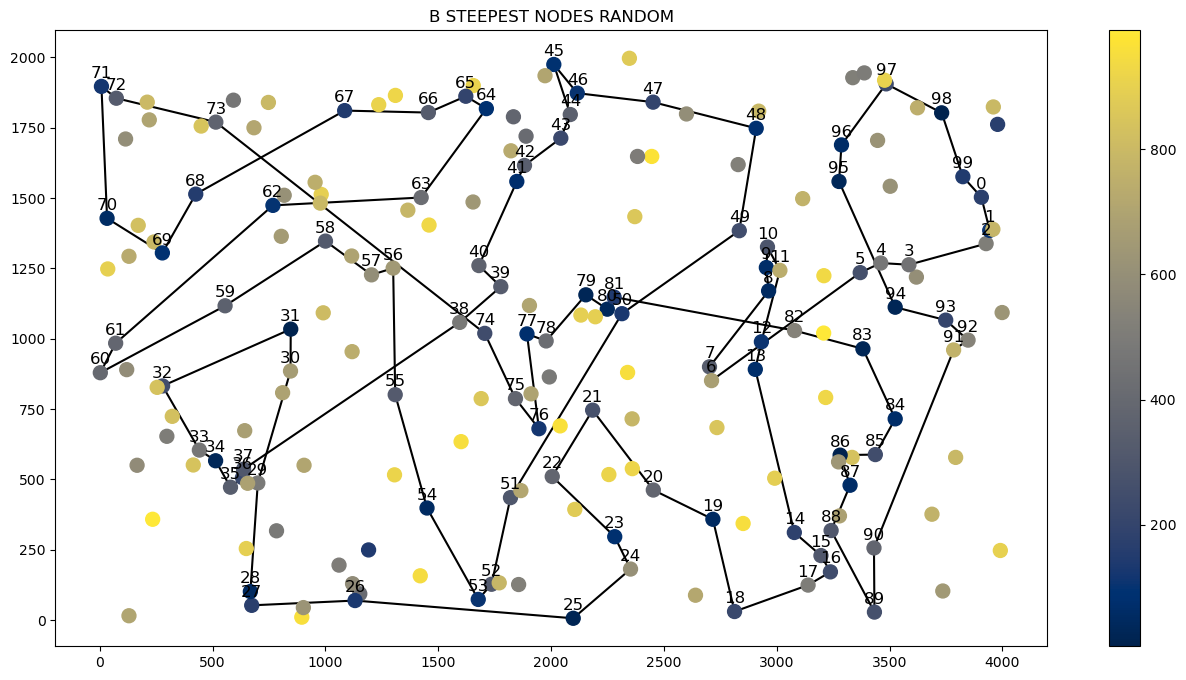

B STEEPEST NODES GREEDY


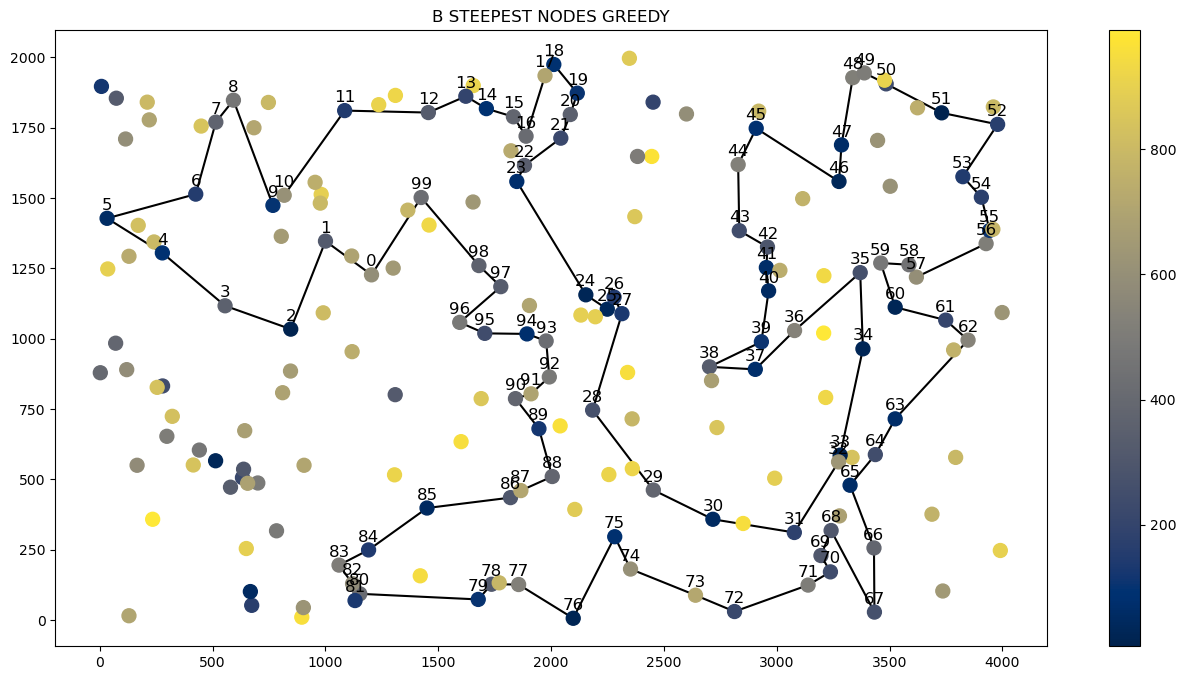

B GREEDY NODES RANDOM


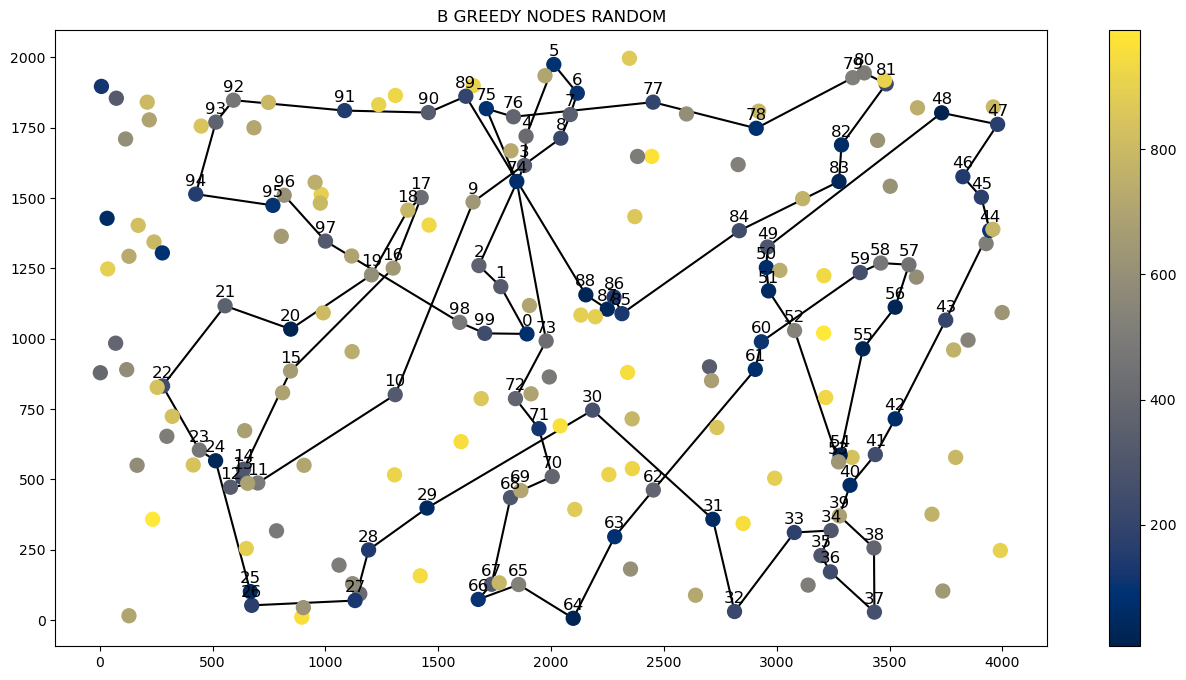

B GREEDY NODES GREEDY


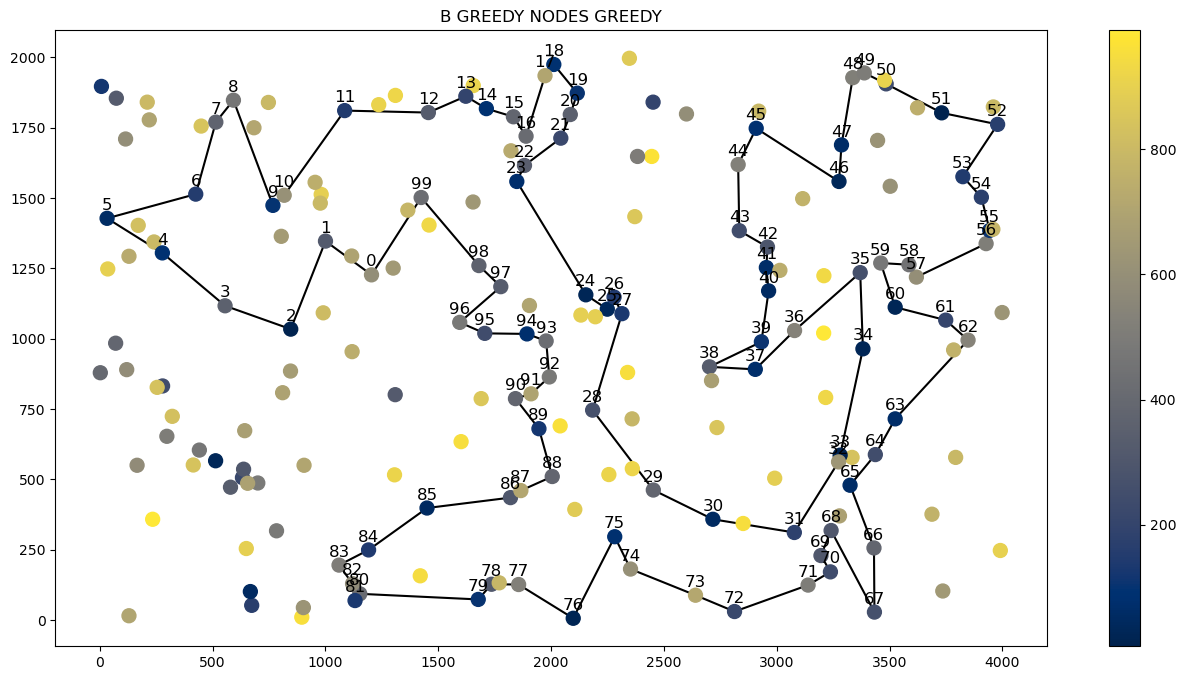

B STEEPEST EDGES RANDOM


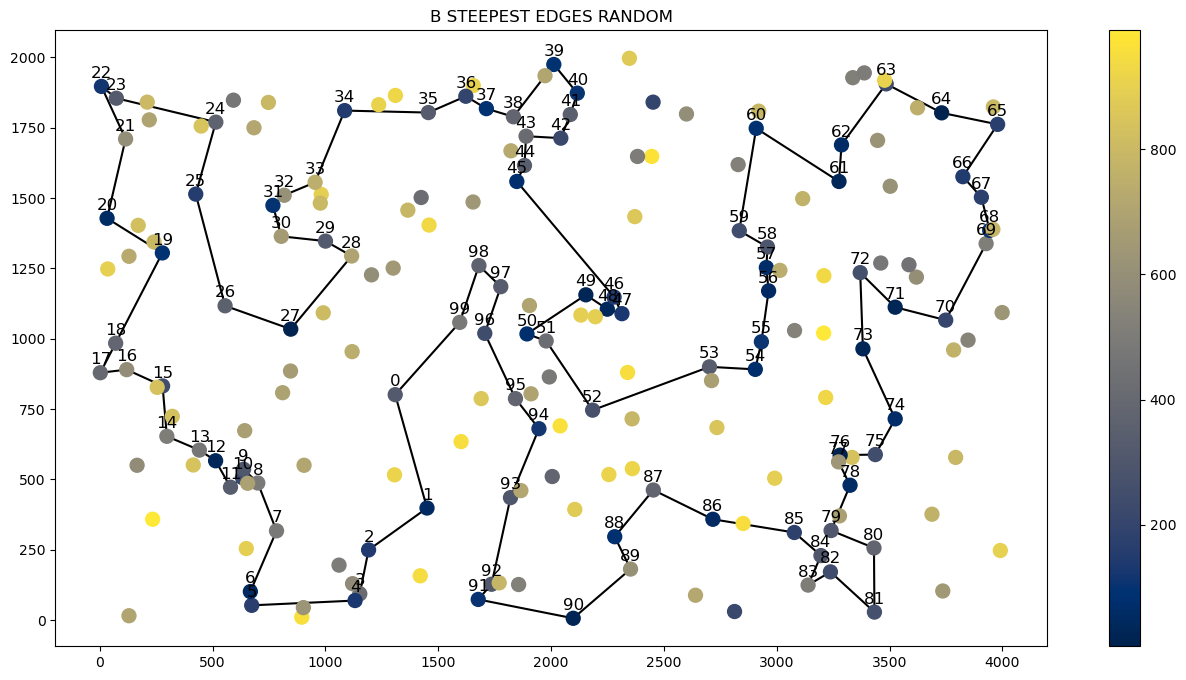

B STEEPEST EDGES GREEDY


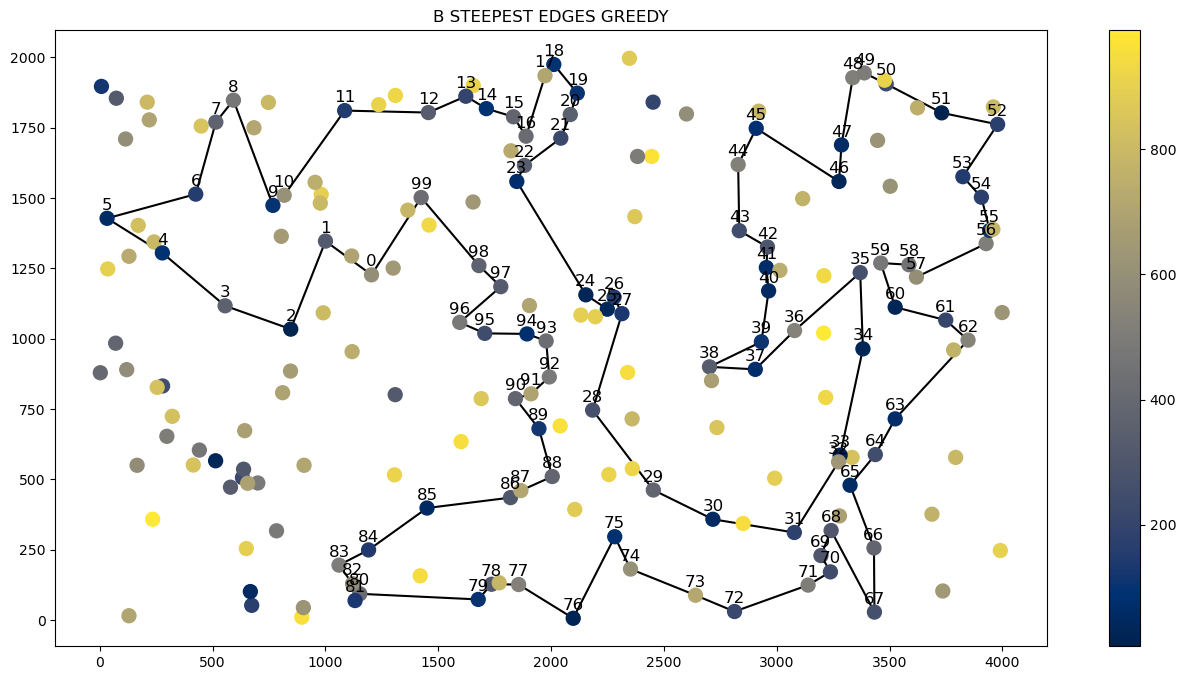

B GREEDY EDGES RANDOM


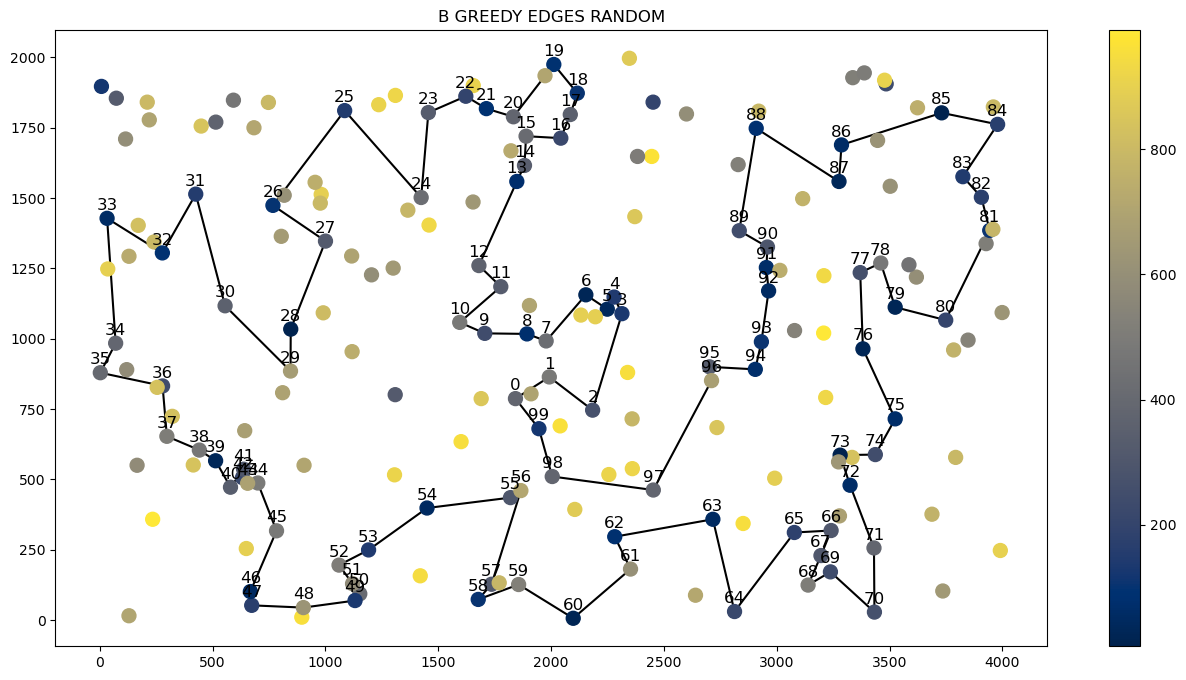

B GREEDY EDGES GREEDY


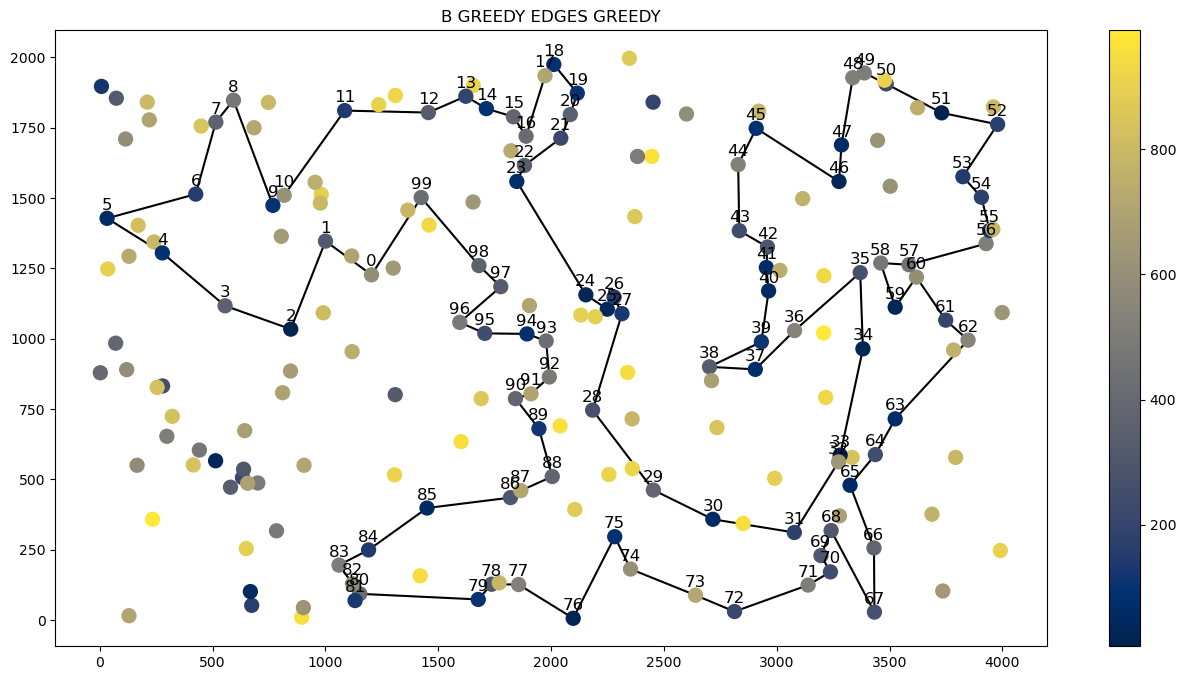

In [5]:
columns = []
experiments = []

for instance in (TspInstance("TSPA.csv"), TspInstance("TSPB.csv")):
    for intra_type in ("nodes", "edges"):
        for steepest in (True, False):
            for initial_solution_getter in (random_solution, greedy_cycle):
                # if intra_type == "nodes" or initial_solution_getter == random_solution or steepest:
                #     continue
                column = f"{instance.file_path[3]} {"steepest" if steepest else "greedy"} {intra_type} {initial_solution_getter.__name__.split("_")[0]}".upper()
                print(column)
                columns.append(column)

                experiments.append(
                    instance.run_experiments(
                        local_search, initial_solution_getter, intra_type, steepest
                    )
                )
                
                instance.plot(experiments[-1][-1], column)

## Previous Methods

<div>
  <style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }

  </style>
  <table border="1" class="dataframe">
    <thead>
      <tr style="text-align: right;">
        <th></th>
        <th>Random A</th>
        <th>NN-End A</th>
        <th>NN-Any A</th>
        <th>Regret A</th>
        <th>Random B</th>
        <th>NN-End B</th>
        <th>NN-Any B</th>
        <th>Regret B</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <th>min</th>
        <td>235530.0</td>
        <td>76880.0</td>
        <td>71255.0</td>
        <td>105692.0</td>
        <td>187468.0</td>
        <td>47940.0</td>
        <td>48973.0</td>
        <td>66162.0</td>
      </tr>
      <tr>
        <th>max</th>
        <td>294275.0</td>
        <td>105198.0</td>
        <td>74220.0</td>
        <td>126951.0</td>
        <td>239215.0</td>
        <td>67185.0</td>
        <td>57348.0</td>
        <td>78406.0</td>
      </tr>
      <tr>
        <th>avg</th>
        <td>264836.7</td>
        <td>83680.24</td>
        <td>72661.445</td>
        <td>115164.15</td>
        <td>213266.78</td>
        <td>52485.63</td>
        <td>51390.06</td>
        <td>72381.19</td>
      </tr>
    </tbody>
  </table>
</div>


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>A - greedy_cycle</th>
      <th>A - weighted_regret</th>
      <th>B - greedy_cycle</th>
      <th>B - weighted_regret</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>71488.000000</td>
      <td>110306.000000</td>
      <td>49177.000000</td>
      <td>74102.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>75528.000000</td>
      <td>173586.000000</td>
      <td>57276.000000</td>
      <td>119091.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>73018.265000</td>
      <td>133603.305000</td>
      <td>51516.000000</td>
      <td>88498.200000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.396144</td>
      <td>0.411771</td>
      <td>0.392464</td>
      <td>0.411223</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>0.502558</td>
      <td>0.465876</td>
      <td>0.482928</td>
      <td>0.561436</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.413238</td>
      <td>0.431047</td>
      <td>0.413838</td>
      <td>0.452695</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
results = pd.DataFrame(
    np.array(tuple(map(lambda x: x[:-1], experiments))).T,
    columns=columns,
    index=(
        "min_cost",
        "max_cost",
        "average_cost",
        "min_time",
        "max_time",
        "average_time",
    ),
)

display(results)
results.to_csv("results_exp3_cycle.csv")

In [ ]:
import pandas as pd
df = pd.read_csv("results_exp3_cycle.csv", index_col=0)

# display separately for instance A and B
df_a = df.iloc[:, :8]
df_b = df.iloc[:, 8:]

# sort columns by column min_cost
df_a = df_a.reindex(df_a.mean().sort_values().index, axis=1)
df_b = df_b.reindex(df_b.mean().sort_values().index, axis=1)

display(df_a)
display(df_b)

# select only without RANDOM 
# df_a1 = df_a.loc[:, df_a.columns.str.contains("RANDOM")] # == False]
# df_b1 = df_b.loc[:, df_b.columns.str.contains("RANDOM")] # == False]

# nodes
# df_a1 = df_a.loc[:, df_a.columns.str.contains("NODES")]
# df_b1 = df_b.loc[:, df_b.columns.str.contains("NODES")]

# # # sort columns by column min_cost
# df_a1 = df_a1.reindex(df_a1.mean().sort_values().index, axis=1)
# df_b1 = df_b1.reindex(df_b1.mean().sort_values().index, axis=1)

# display(df_a1)
# display(df_b1)

# # not random
# # df_a2 = df_a.loc[:, df_a.columns.str.contains("RANDOM") == False]
# # df_b2 = df_b.loc[:, df_b.columns.str.contains("RANDOM") == False]

# df_a2 = df_a.loc[:, df_a.columns.str.contains("EDGES")]
# df_b2 = df_b.loc[:, df_b.columns.str.contains("EDGES")]

# display(df_a2)
# display(df_b2)

## Random

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>A GREEDY EDGES RANDOM</th>
      <th>A STEEPEST EDGES RANDOM</th>
      <th>A GREEDY NODES RANDOM</th>
      <th>A STEEPEST NODES RANDOM</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>71145.000000</td>
      <td>71691.000000</td>
      <td>78150.000000</td>
      <td>79825.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>76165.000000</td>
      <td>77652.000000</td>
      <td>93400.000000</td>
      <td>94638.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>73385.850000</td>
      <td>73938.370000</td>
      <td>85730.455000</td>
      <td>88064.770000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.558725</td>
      <td>2.987703</td>
      <td>0.569081</td>
      <td>3.616727</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>1.430489</td>
      <td>4.465888</td>
      <td>1.859496</td>
      <td>6.170017</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.998886</td>
      <td>3.611487</td>
      <td>1.111895</td>
      <td>4.707244</td>
    </tr>
  </tbody>
</table>
</div>
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>B STEEPEST EDGES RANDOM</th>
      <th>B GREEDY EDGES RANDOM</th>
      <th>B GREEDY NODES RANDOM</th>
      <th>B STEEPEST NODES RANDOM</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>45431.000000</td>
      <td>45708.000000</td>
      <td>54160.000000</td>
      <td>55914.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>51965.000000</td>
      <td>52449.000000</td>
      <td>69687.000000</td>
      <td>70345.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>48379.710000</td>
      <td>48185.150000</td>
      <td>60831.555000</td>
      <td>62907.130000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>3.078604</td>
      <td>0.365434</td>
      <td>0.449705</td>
      <td>3.768656</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>4.357592</td>
      <td>1.052611</td>
      <td>1.521771</td>
      <td>6.630726</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>3.617369</td>
      <td>0.694505</td>
      <td>0.801365</td>
      <td>4.748056</td>
    </tr>
  </tbody>
</table>
</div>

## Greedy Cycle

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>A GREEDY EDGES GREEDY</th>
      <th>A STEEPEST EDGES GREEDY</th>
      <th>A GREEDY NODES GREEDY</th>
      <th>A STEEPEST NODES GREEDY</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>70014.000000</td>
      <td>70439.000000</td>
      <td>71285.000000</td>
      <td>71285.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>73302.000000</td>
      <td>73287.000000</td>
      <td>73863.000000</td>
      <td>73863.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>71639.040000</td>
      <td>71628.765000</td>
      <td>72332.275000</td>
      <td>72334.620000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.313843</td>
      <td>0.346553</td>
      <td>0.304606</td>
      <td>0.305514</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>0.673035</td>
      <td>0.868734</td>
      <td>0.474632</td>
      <td>1.020290</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.440710</td>
      <td>0.535067</td>
      <td>0.374755</td>
      <td>0.445421</td>
    </tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>B STEEPEST NODES GREEDY</th>
      <th>B GREEDY NODES GREEDY</th>
      <th>B STEEPEST EDGES GREEDY</th>
      <th>B GREEDY EDGES GREEDY</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>48305.000000</td>
      <td>48305.000000</td>
      <td>48305.000000</td>
      <td>48383.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>56856.000000</td>
      <td>56856.000000</td>
      <td>56800.000000</td>
      <td>56872.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>50838.195000</td>
      <td>50852.600000</td>
      <td>50736.525000</td>
      <td>50748.775000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.435851</td>
      <td>0.329647</td>
      <td>0.441677</td>
      <td>0.352116</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>0.950449</td>
      <td>0.728349</td>
      <td>0.894659</td>
      <td>0.574690</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.609810</td>
      <td>0.426938</td>
      <td>0.578302</td>
      <td>0.430243</td>
    </tr>
  </tbody>
</table>
</div>

# Conlusions:
- Comparing new methods 
    - Most of methods which started from greedy-cycle solution had better results than random starting solution, suprisingly for instance B and method greedy and steepest intra-edges we get worse results for our heuristic, than for random solution, which we can explain, that our LS (Local Search) method didn't get stuck in some local optimum for random solution. 
    - All plots of edges, don't have any crossing edge.
    - Methods not using random starting solutions were far faster than using our heuristic starting solution
    - As expected, for all cases, steepest performed longer till found its solution
    - Intra-edges changes worked better, for almost all cases we get better objective function value or slightly worse/equal, except of LS-Greedy with random starting solution
    - In our experiment, we didn't see if using Steepest method or LS-Greedy method work better, as the results are very similar
- Comparing with meethods from the previous laboratories
    - We get new best methods, 
        - For instance A, we get LS-Greedy and Steepest edges with starting solution of greedy cycle
        - For instance B, we get LS-Greedy and Steepest edges with random starting solution